In [133]:
import numpy as np
import pandas as pan
import matplotlib.pyplot as plot
%matplotlib inline
import itertools
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from numpy import mean
from numpy import absolute
from numpy import sqrt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import RepeatedKFold

# Read wine data
wine = pan.read_csv('wine.txt', sep="\t", header=0)
# Show data
print(wine)

    Clarity  Aroma  Body  Flavor  Oakiness  Quality  Region
0       1.0    3.3   2.8     3.1       4.1      9.8       1
1       1.0    4.4   4.9     3.5       3.9     12.6       1
2       1.0    3.9   5.3     4.8       4.7     11.9       1
3       1.0    3.9   2.6     3.1       3.6     11.1       1
4       1.0    5.6   5.1     5.5       5.1     13.3       1
5       1.0    4.6   4.7     5.0       4.1     12.8       1
6       1.0    4.8   4.8     4.8       3.3     12.8       1
7       1.0    5.3   4.5     4.3       5.2     12.0       1
8       1.0    4.3   4.3     3.9       2.9     13.6       3
9       1.0    4.3   3.9     4.7       3.9     13.9       1
10      1.0    5.1   4.3     4.5       3.6     14.4       3
11      0.5    3.3   5.4     4.3       3.6     12.3       2
12      0.8    5.9   5.7     7.0       4.1     16.1       3
13      0.7    7.7   6.6     6.7       3.7     16.1       3
14      1.0    7.1   4.4     5.8       4.1     15.5       3
15      0.9    5.5   5.6     5.6       4

In [3]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Clarity   38 non-null     float64
 1   Aroma     38 non-null     float64
 2   Body      38 non-null     float64
 3   Flavor    38 non-null     float64
 4   Oakiness  38 non-null     float64
 5   Quality   38 non-null     float64
 6   Region    38 non-null     int64  
dtypes: float64(6), int64(1)
memory usage: 2.2 KB


In [181]:
X = wine.drop('Quality', axis=1)
y = wine['Quality']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=10)

lr = LinearRegression()
cv = LeaveOneOut()
scores = cross_val_score(lr, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

#view mean absolute error
lr_test = mean(absolute(scores))
lr_test

1.2664374017142526

In [173]:
lr.fit(X_train, y_train)
print(lr.intercept_, lr.coef_, lr.score(X, y))

3.0054690303396594 [ 2.0694319   0.51639939  0.53156728  1.20041551 -0.7776024   0.01997731] 0.7006617884846797


In [54]:
# Best Subset Selection
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

def getBest(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo)) 
    # Wrap everything up in a nice dataframe
    models = pan.DataFrame(results)
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

models_best = pan.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,7):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 6 models on 1 predictors in 0.05510997772216797 seconds.
Processed 15 models on 2 predictors in 0.0474393367767334 seconds.
Processed 20 models on 3 predictors in 0.06509566307067871 seconds.
Processed 15 models on 4 predictors in 0.04218149185180664 seconds.
Processed 6 models on 5 predictors in 0.027566194534301758 seconds.
Processed 1 models on 6 predictors in 0.006474494934082031 seconds.
Total elapsed time: 0.26894092559814453 seconds.


In [55]:
models_best

,RSS,model
1,98.346061,<statsmodels.regression.linear_model.Regressio...
2,61.789657,<statsmodels.regression.linear_model.Regressio...
3,57.04904,<statsmodels.regression.linear_model.Regressio...
4,50.870419,<statsmodels.regression.linear_model.Regressio...
5,47.582677,<statsmodels.regression.linear_model.Regressio...
6,47.527237,<statsmodels.regression.linear_model.Regressio...


In [56]:
print(models_best.loc[1, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                Quality   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              2233.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):                    1.11e-34
Time:                        14:50:31   Log-Likelihood:                         -71.987
No. Observations:                  38   AIC:                                      146.0
Df Residuals:                      37   BIC:                                      147.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [57]:
print(models_best.loc[2, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                Quality   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                              1739.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):                    1.54e-36
Time:                        14:50:33   Log-Likelihood:                         -63.157
No. Observations:                  38   AIC:                                      130.3
Df Residuals:                      36   BIC:                                      133.6
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [58]:
print(models_best.loc[3, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                Quality   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              1222.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):                    1.81e-35
Time:                        14:50:35   Log-Likelihood:                         -61.640
No. Observations:                  38   AIC:                                      129.3
Df Residuals:                      35   BIC:                                      134.2
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [59]:
print(models_best.loc[4, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                Quality   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              999.5
Date:                Wed, 29 Mar 2023   Prob (F-statistic):                    9.85e-35
Time:                        14:50:37   Log-Likelihood:                         -59.462
No. Observations:                  38   AIC:                                      126.9
Df Residuals:                      34   BIC:                                      133.5
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [60]:
print(models_best.loc[5, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                Quality   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              830.1
Date:                Wed, 29 Mar 2023   Prob (F-statistic):                    1.11e-33
Time:                        14:50:39   Log-Likelihood:                         -58.192
No. Observations:                  38   AIC:                                      126.4
Df Residuals:                      33   BIC:                                      134.6
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [61]:
print(models_best.loc[6, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                Quality   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              671.6
Date:                Wed, 29 Mar 2023   Prob (F-statistic):                    3.32e-32
Time:                        14:50:42   Log-Likelihood:                         -58.170
No. Observations:                  38   AIC:                                      128.3
Df Residuals:                      32   BIC:                                      138.2
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Text(0, 0.5, 'BIC')

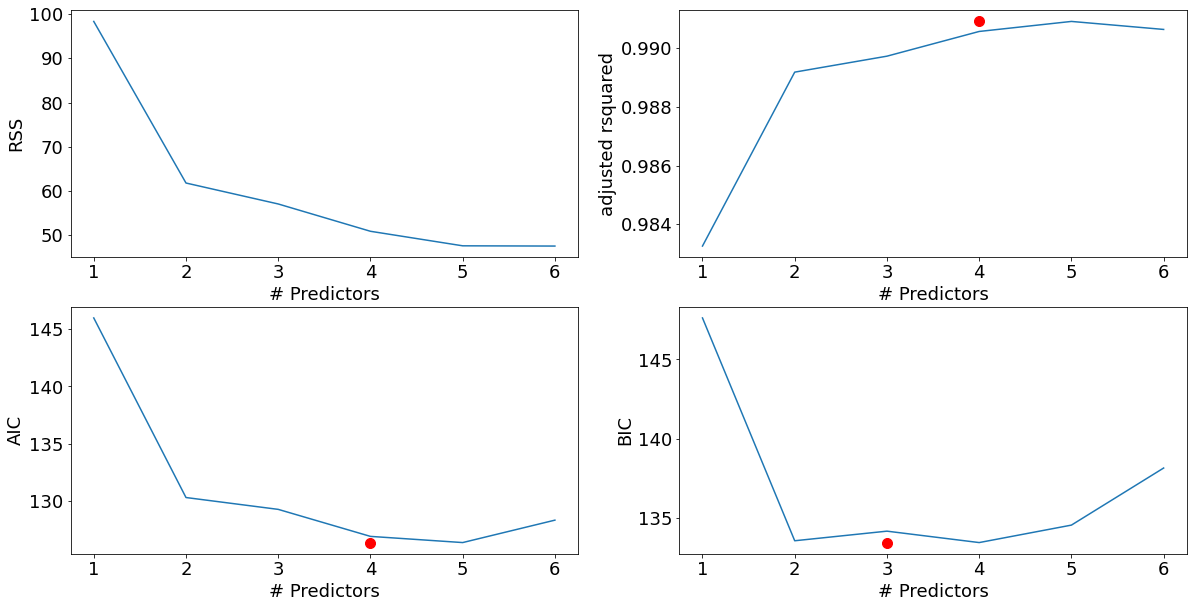

In [62]:
plot.figure(figsize=(20,10))
plot.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plot.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plot.plot(models_best["RSS"])
plot.xlabel('# Predictors')
plot.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plot.subplot(2, 2, 2)
plot.plot(rsquared_adj)
plot.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plot.xlabel('# Predictors')
plot.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plot.subplot(2, 2, 3)
plot.plot(aic)
plot.plot(aic.argmin(), aic.min(), "or")
plot.xlabel('# Predictors')
plot.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plot.subplot(2, 2, 4)
plot.plot(bic)
plot.plot(bic.argmin(), bic.min(), "or")
plot.xlabel('# Predictors')
plot.ylabel('BIC')

In [163]:
# Test MSE for Model with 4 variables 
X = wine[['Clarity', 'Body', 'Flavor', 'Oakiness']]
y = wine['Quality']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=10)

model1 = LinearRegression()
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)
model1_test = mean_squared_error(y_pred, y_test)
print("Test MSE = ", model1_test)

Test MSE =  1.2767670288530615


In [70]:
X = wine.drop('Quality', axis=1)
y = wine['Quality']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=10)

In [71]:
# Forward Stepwise Selection
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pan.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

models_fwd = pan.DataFrame(columns=["RSS", "model"])

tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  6 models on 1 predictors in 0.016231298446655273 seconds.
Processed  5 models on 2 predictors in 0.017084121704101562 seconds.
Processed  4 models on 3 predictors in 0.012479543685913086 seconds.
Processed  3 models on 4 predictors in 0.009078502655029297 seconds.
Processed  2 models on 5 predictors in 0.0066645145416259766 seconds.
Processed  1 models on 6 predictors in 0.004609107971191406 seconds.
Total elapsed time: 0.07904815673828125 seconds.


In [72]:
print(models_fwd.loc[1, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                Quality   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              2233.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):                    1.11e-34
Time:                        14:58:48   Log-Likelihood:                         -71.987
No. Observations:                  38   AIC:                                      146.0
Df Residuals:                      37   BIC:                                      147.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [73]:
print(models_fwd.loc[2, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                Quality   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                              1739.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):                    1.54e-36
Time:                        14:59:00   Log-Likelihood:                         -63.157
No. Observations:                  38   AIC:                                      130.3
Df Residuals:                      36   BIC:                                      133.6
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [75]:
print(models_fwd.loc[3, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                Quality   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              1222.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):                    1.81e-35
Time:                        14:59:14   Log-Likelihood:                         -61.640
No. Observations:                  38   AIC:                                      129.3
Df Residuals:                      35   BIC:                                      134.2
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [76]:
print(models_fwd.loc[4, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                Quality   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              999.5
Date:                Wed, 29 Mar 2023   Prob (F-statistic):                    9.85e-35
Time:                        14:59:26   Log-Likelihood:                         -59.462
No. Observations:                  38   AIC:                                      126.9
Df Residuals:                      34   BIC:                                      133.5
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [77]:
print(models_fwd.loc[5, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                Quality   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              830.1
Date:                Wed, 29 Mar 2023   Prob (F-statistic):                    1.11e-33
Time:                        14:59:34   Log-Likelihood:                         -58.192
No. Observations:                  38   AIC:                                      126.4
Df Residuals:                      33   BIC:                                      134.6
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [78]:
print(models_fwd.loc[6, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                Quality   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              671.6
Date:                Wed, 29 Mar 2023   Prob (F-statistic):                    3.32e-32
Time:                        14:59:41   Log-Likelihood:                         -58.170
No. Observations:                  38   AIC:                                      128.3
Df Residuals:                      32   BIC:                                      138.2
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Text(0, 0.5, 'BIC')

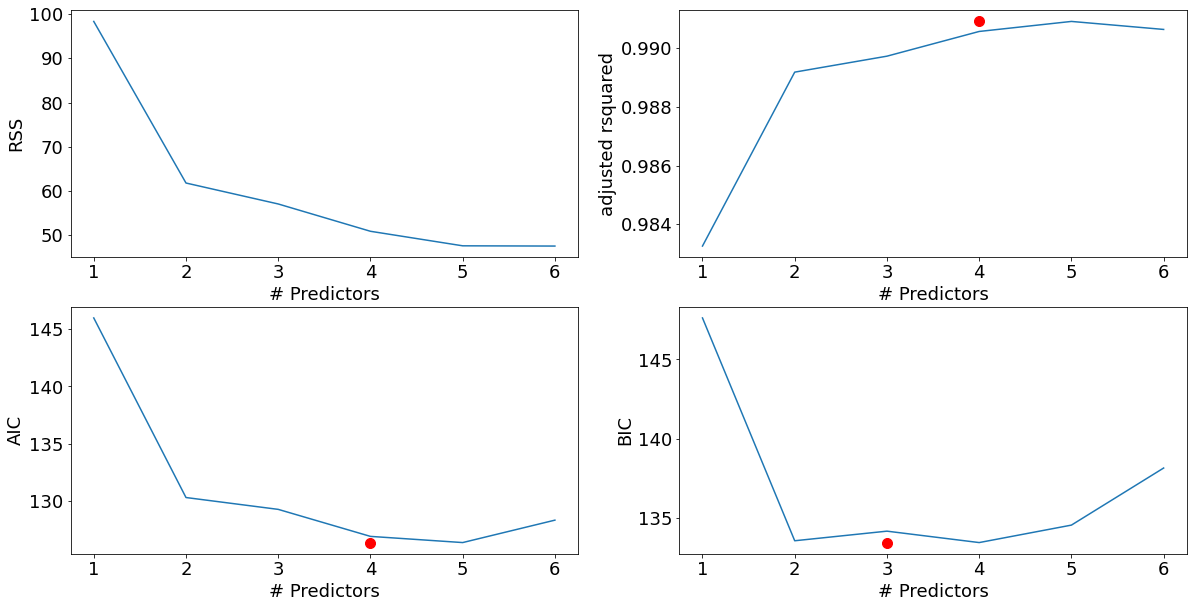

In [100]:
plot.figure(figsize=(20,10))
plot.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plot.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plot.plot(models_fwd["RSS"])
plot.xlabel('# Predictors')
plot.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_fwd.apply(lambda row: row[1].rsquared_adj, axis=1)

plot.subplot(2, 2, 2)
plot.plot(rsquared_adj)
plot.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plot.xlabel('# Predictors')
plot.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_fwd.apply(lambda row: row[1].aic, axis=1)

plot.subplot(2, 2, 3)
plot.plot(aic)
plot.plot(aic.argmin(), aic.min(), "or")
plot.xlabel('# Predictors')
plot.ylabel('AIC')

bic = models_fwd.apply(lambda row: row[1].bic, axis=1)

plot.subplot(2, 2, 4)
plot.plot(bic)
plot.plot(bic.argmin(), bic.min(), "or")
plot.xlabel('# Predictors')
plot.ylabel('BIC')

In [166]:
# Test MSE for Model with 4 variables 
X = wine[['Clarity', 'Body', 'Flavor', 'Oakiness']]
y = wine['Quality']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=10)

model2 = LinearRegression()
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
model2_test = mean_squared_error(y_pred, y_test)
print("Test MSE = ", model2_test)

Test MSE =  1.2767670288530615


In [80]:
X = wine.drop('Quality', axis=1)
y = wine['Quality']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=10)

In [83]:
# Backwards Selection
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pan.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

models_bwd = pan.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))

tic = time.time()
predictors = X.columns

while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  6 models on 5 predictors in 0.021027088165283203 seconds.
Processed  5 models on 4 predictors in 0.01825881004333496 seconds.
Processed  4 models on 3 predictors in 0.009508371353149414 seconds.
Processed  3 models on 2 predictors in 0.010406255722045898 seconds.
Processed  2 models on 1 predictors in 0.006006956100463867 seconds.
Total elapsed time: 0.06970930099487305 seconds.


In [84]:
print(models_bwd.loc[1, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                Quality   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              2233.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):                    1.11e-34
Time:                        15:04:20   Log-Likelihood:                         -71.987
No. Observations:                  38   AIC:                                      146.0
Df Residuals:                      37   BIC:                                      147.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [85]:
print(models_bwd.loc[2, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                Quality   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                              1739.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):                    1.54e-36
Time:                        15:04:31   Log-Likelihood:                         -63.157
No. Observations:                  38   AIC:                                      130.3
Df Residuals:                      36   BIC:                                      133.6
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [86]:
print(models_bwd.loc[3, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                Quality   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              1222.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):                    1.81e-35
Time:                        15:04:38   Log-Likelihood:                         -61.640
No. Observations:                  38   AIC:                                      129.3
Df Residuals:                      35   BIC:                                      134.2
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [87]:
print(models_bwd.loc[4, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                Quality   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              999.5
Date:                Wed, 29 Mar 2023   Prob (F-statistic):                    9.85e-35
Time:                        15:04:45   Log-Likelihood:                         -59.462
No. Observations:                  38   AIC:                                      126.9
Df Residuals:                      34   BIC:                                      133.5
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [88]:
print(models_bwd.loc[5, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                Quality   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              830.1
Date:                Wed, 29 Mar 2023   Prob (F-statistic):                    1.11e-33
Time:                        15:04:51   Log-Likelihood:                         -58.192
No. Observations:                  38   AIC:                                      126.4
Df Residuals:                      33   BIC:                                      134.6
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Text(0, 0.5, 'BIC')

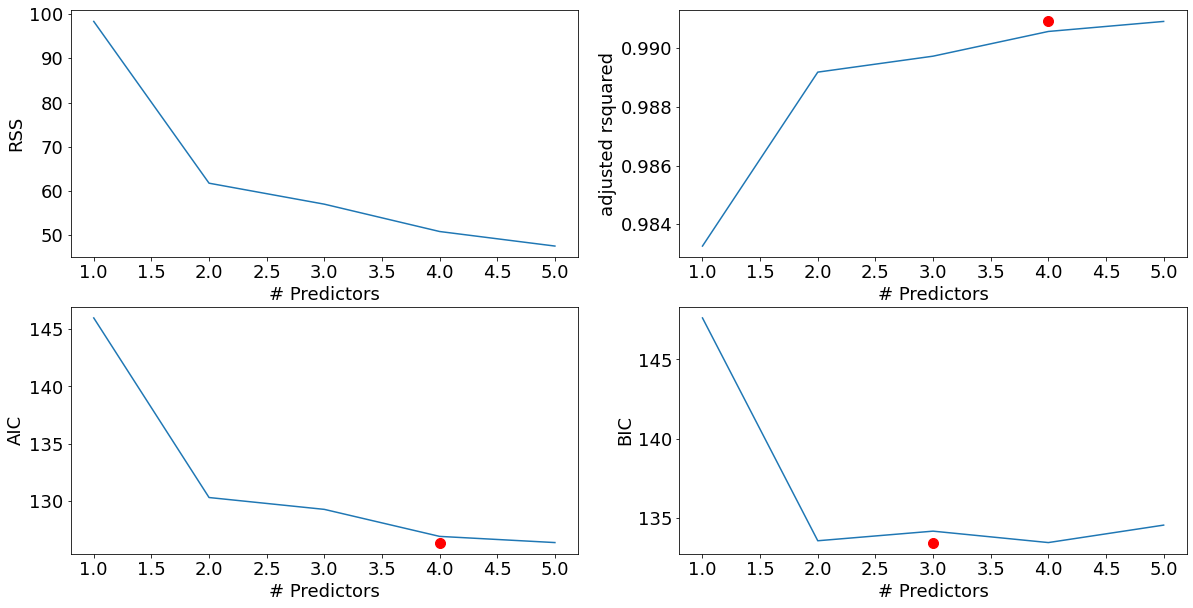

In [101]:
plot.figure(figsize=(20,10))
plot.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plot.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plot.plot(models_bwd["RSS"])
plot.xlabel('# Predictors')
plot.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_bwd.apply(lambda row: row[1].rsquared_adj, axis=1)

plot.subplot(2, 2, 2)
plot.plot(rsquared_adj)
plot.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plot.xlabel('# Predictors')
plot.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_bwd.apply(lambda row: row[1].aic, axis=1)

plot.subplot(2, 2, 3)
plot.plot(aic)
plot.plot(aic.argmin(), aic.min(), "or")
plot.xlabel('# Predictors')
plot.ylabel('AIC')

bic = models_bwd.apply(lambda row: row[1].bic, axis=1)

plot.subplot(2, 2, 4)
plot.plot(bic)
plot.plot(bic.argmin(), bic.min(), "or")
plot.xlabel('# Predictors')
plot.ylabel('BIC')

In [167]:
# Test MSE for Model with 4 variables 
X = wine[['Clarity', 'Body', 'Flavor', 'Oakiness']]
y = wine['Quality']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=10)

model3 = LinearRegression()
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
model3_test = mean_squared_error(y_pred, y_test)
print("Test MSE = ", model3_test)

Test MSE =  1.2767670288530615


In [170]:
X = wine.drop('Quality', axis=1)
y = wine['Quality']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=10)

# Ridge Regression
# define evaluation
cv = LeaveOneOut()
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
model4 = Ridge()
model4.fit(X_train,y_train)
scores = cross_val_score(model4, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#view mean absolute error
model4_test = mean(absolute(scores))
print("Test MSE = ", model4_test)

Test MSE =  1.1463948724715238


In [171]:
# Lasso Regression
# define evaluation
cv = LeaveOneOut()
# define model
model5 = Lasso()
model5.fit(X_train,y_train)
scores = cross_val_score(model5, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#view mean absolute error
model5_test = mean(absolute(scores))
print("Test MSE = ", model5_test)

Test MSE =  1.6257986177955628


In [180]:
df = pan.DataFrame({
   'ColumnA': [lr.coef_, lr_test],
   'ColumnB': [model1.coef_, model1_test],
   'ColumnC': [model2.coef_, model2_test],
   'ColumnD': [model3.coef_, model3_test],
   'ColumnE': [model4.coef_, model4_test],
   'ColumnF': [model5.coef_, model5_test]
},
index=["Parameter Estimates","Test MSE"])
df.columns=['LinReg', 'BestSub', 'ForwS', 'BackS', 'Ridge', 'Lasso']
print(df)

                                                                LinReg  \
Parameter Estimates  [2.0694318952581705, 0.5163993944124755, 0.531...   
Test MSE                                                      1.266437   

                                                               BestSub  \
Parameter Estimates  [3.0614723208405006, 0.6915595636655764, 1.431...   
Test MSE                                                      1.276767   

                                                                 ForwS  \
Parameter Estimates  [3.0614723208405006, 0.6915595636655764, 1.431...   
Test MSE                                                      1.276767   

                                                                 BackS  \
Parameter Estimates  [3.0614723208405006, 0.6915595636655764, 1.431...   
Test MSE                                                      1.276767   

                                                                 Ridge  \
Parameter Estimates  [0.4963433222